In [1]:
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import math
import numpy as np
import imageio
import sklearn.cluster as skclust 

def load_all_fitnesses(filename,obj) :
    with open(filename) as file :
        csv_data = csv.reader(file,delimiter=',')
        best_fitnesses = []
        best_ind_id = []
        avg_fitnesses = []
        pop_size= []
        nb_eval = []
        nb_eval_tot = 0
        for row in csv_data :
            best_fitness = 0
            best_id = 0
            avg_fitness = 0
            nb_eval_tot += int(row[1])
            for i in range(3,len(row[:-1]),int(row[2])) :
                if(float(row[i+obj]) > best_fitness) :
                    best_fitness = float(row[i+obj])
                    best_id = int(i/int(row[2]) - 1)
                avg_fitness += float(row[i+obj])
            avg_fitness = avg_fitness/float(row[1])
            avg_fitnesses.append(avg_fitness)
            best_fitnesses.append(best_fitness)
            best_ind_id.append(best_id)
            nb_eval.append(nb_eval_tot)
            pop_size.append(int(row[1]))
            
    return nb_eval, best_ind_id, best_fitnesses, avg_fitnesses, pop_size

def load_score(filename) :
    with open(filename) as file :
        csv_data = csv.reader(file,delimiter=',')
        score = []
        nb_eval = []
        n_eval_tot = 0
        pop_size = []
        for row in csv_data :
            for i in range(2,len(row[:-1])) :
                n_eval_tot+=1
                score.append(float(row[i]))    
                nb_eval.append(n_eval_tot)
            pop_size.append(int(row[1]))
            
    return nb_eval, pop_size, score

def load_fitness_of_gen(filename,obj,gen) :
    with open(filename) as file :
        csv_data = csv.reader(file,delimiter=',')
        fitnesses = []
        for row in csv_data :
            if(int(row[0]) == 0) :
                for i in range(3,len(row[:-1]),int(row[2])) :
                     fitnesses.append(float(row[i+obj]))
                break
    return fitnesses

def load_robustness_score(filename) :
    with open(filename) as file :
        csv_data = csv.reader(file,delimiter=',')
        pop_size = [int(row[1]) for i,row in enumerate(csv_data) if i == 0]
        fitnesses = [[] for _ in range(pop_size[0])]
    with open(filename) as file :
        csv_data = csv.reader(file,delimiter=',')
        for row in csv_data :
            for i in range(3,len(row[:-1])) :
                fitnesses[i-3].append(float(row[i]))
    return fitnesses

def load_best_fit_mo(filename) :
    with open(filename) as file :
        csv_data = csv.reader(file,delimiter=',')
        best_fit1 = []
        best_fit2 = []
        pop_size= []
        nb_eval = []
        nb_eval_tot = 0
        for row in csv_data :
            best_fitness = [0,0]
            avg_fitness = 0
            nb_eval_tot += int(row[1])
            for i in range(3,len(row[:-1]),int(row[2])) :
                if(float(row[i]) > best_fitness[0]) :
                    best_fitness = [float(row[i]),float(row[i+1])]
                    
            best_fit1.append(best_fitness[0])
            best_fit2.append(best_fitness[1])
            nb_eval.append(nb_eval_tot)
            pop_size.append(float(row[1]))
            
    return nb_eval, best_fit1, best_fit2, pop_size


def histo_nbeval(nbeval,bins) :
    histo = [0 for b in bins]
    for nbe in nbeval :
        for i in range(0,len(bins)) :
            if(nbe < int(bins[i])) :
                histo[i] += 1
                break
    for i in range(0,len(histo)) :
        histo[i] = float(histo[i])/float(len(nbeval))*100
    return histo

def best_fit(fitnesses_vec,from_i) :
    best_fits = []
    for fits in fitnesses_vec :
        best_fits.append(max(fits[from_i:]))
    return best_fits

def load_eval_time(filename) :
    with open(filename) as file :
        csv_data = csv.reader(file,delimiter=',')
        durations = []
        eval_nb = []
        for row in csv_data :
            durations.append(float(row[1])*1e-9)
            eval_nb.append(int(row[0]))
    return eval_nb, durations

def load_all_fit_from_fpos(filename,target) :
    best_fitnesses = []
    avg_fitnesses = []
    pop_size= []
    nb_eval = []
    with open(filename) as file :
        csv_data = csv.reader(file,delimiter=',')
        nb_eval_tot = 0
        for row in csv_data :
            fitnesses = []
            nb_eval_tot+=len(row[2:])/4
            for i in range(2,int(len(row[2:])/4),4) :
                fitnesses.append(compute_reward([float(row[i+1]),float(row[i+2])],target))
            best_fitnesses.append(max(fitnesses))
            avg_fitnesses.append(np.mean(fitnesses))
            pop_size.append(len(row[2:])/4)
            nb_eval.append(nb_eval_tot)
    return nb_eval, best_fitnesses, avg_fitnesses, pop_size

def load_final_pos(filename,pop,gen) :
    with open(filename) as file :
        csv_data = csv.reader(file,delimiter=',')
        x = []
        y = []
        for row in csv_data :
            if(float(row[1]) == gen) :
                i = 0
                j = 2
                while(i < pop - 1):
                    if(j >= len(row) -1) :
                        break
                    if(float(row[j]) == i and float(row[j+1]) != i+1) :
                        x.append(float(row[j+1]))
                        y.append(float(row[j+2]))
                        j+=3
                    
                    j+=1
                    i+=1
                break
        return x, y

    
def load_obs(filename) :
    with open(filename) as file :
        csv_data = csv.reader(file,delimiter=',')
        x = []
        y = []
        for row in csv_data :
            x.append(float(row[2]))
            y.append(float(row[3]))
    return x, y
    
def compute_reward(final_pos,target) :
    return 1 - math.sqrt((final_pos[0] - target[0])**2 + (final_pos[1] - target[1])**2)/math.sqrt(2**3)

def rewards(positions,target) :
    r = []
    for pos in positions :
        r.append(compute_reward(pos,target))
    return r

def animation_pop(foldername,pop_size,step) :
    plt.ioff()
    images = []
    for i in range(0,len(pop_size),step) :
        x_vec = []
        y_vec = []
        if(not os.path.isdir(foldername)) :
            continue
        x, y = load_final_pos(foldername + "/final_pos.csv",pop_size[i],i)
        x_vec = x_vec + x
        y_vec = y_vec + y   
                
        fig2, ax2 = plt.subplots(figsize=[10,10])
        ax2.set_ylim(-1.,1.)
        ax2.set_xlim(-1.,1.)
        plt.title("Generation " + str(i))
        plt.plot(x_vec,y_vec,'o')
        plt.savefig(foldername + "/pop_" + str(i) + ".jpg")
        plt.close(fig2)
        images.append(imageio.imread(foldername + "/pop_" + str(i) + ".jpg"))
    imageio.mimwrite(foldername + "_pop_gen.gif",images)

def load_descriptor(filename,desc_size) :
    '''
    Load a list of descriptor from a file
    Trait descriptor: <width,depth,height,voxels,wheels,sensor,joint,caster>
    '''
    with open(filename) as file :
        print(filename)
        csv_data = csv.reader(file,delimiter=',')
        descriptors = []
        for row in csv_data :
            desc = []
            for i in range(desc_size) :
                desc.append(float(row[i+1]))
            descriptors.append(desc)
        return np.array(descriptors)
    
def read_parameters(filename):
    '''
    Read a parameter and return a dictionnary
    '''
    parameters = dict()
    with open(filename) as file :
        print(filename)
        csv_data = csv.reader(file,delimiter=',')
        for row in csv_data:
            parameters[row[0]] = row[2]
    return parameters

[(0, 7, 0.187845), (1, 0, 0.198895), (2, 1, 0.19337), (3, 3, 0.110497), (4, 6, 0.198895), (5, 4, 0.121547), (6, 2, 0.132597), (7, 4, 0.18232), (8, 3, 0.154696), (9, 3, 0.259669), (10, 5, 0.19337), (11, 3, 0.171271), (12, 7, 0.121547), (13, 1, 0.165746), (14, 1, 0.270718), (15, 5, 0.303867), (16, 3, 0.353591), (17, 0, 0.0939227), (18, 8, 0.392265), (19, 7, 0.248619), (20, 1, 0.348066), (21, 2, 0.254144), (22, 4, 0.220994), (23, 4, 0.171271), (24, 1, 0.270718), (25, 0, 0.276243), (26, 6, 0.243094), (27, 5, 0.243094), (28, 5, 0.314917), (29, 1, 0.292818), (30, 6, 0.375691), (31, 5, 0.265193), (32, 6, 0.325967), (33, 1, 0.187845), (34, 6, 0.248619), (35, 9, 0.165746), (36, 9, 0.116022), (37, 4, 0.254144), (38, 1, 0.171271), (39, 9, 0.110497), (40, 8, 0.154696), (41, 3, 0.232044), (42, 6, 0.160221), (43, 8, 0.270718), (44, 0, 0.281768), (45, 3, 0.265193), (46, 4, 0.276243), (47, 8, 0.254144), (48, 7, 0.359116), (49, 0, 0.392265), (50, 3, 0.259669), (51, 8, 0.381215), (52, 6, 0.337017), (53,

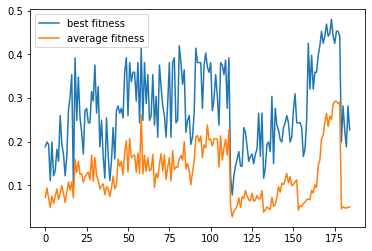

In [24]:
exp_folder = "/home/le_goff/are-logs/nipes_pretraining/exploration/177/nipes_13_8_17-25-52-2915-2631521776/"
neval, best_id, best_fit, avg_fit,pop_size = load_all_fitnesses(exp_folder + "/fitnesses.csv",0)
gen = range(len(best_fit))
fit_id = [(g,i,fit) for g,i,fit in zip(gen,best_id,best_fit)]

print(fit_id)

plt.plot(gen,best_fit,avg_fit)
plt.legend(["best fitness","average fitness","number of eval"])
plt.show()

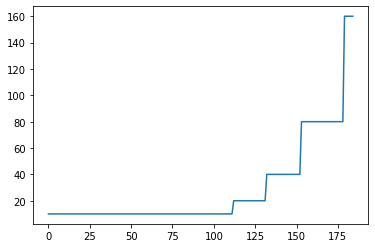

In [23]:
plt.plot(gen,pop_size)